In [1]:
import numpy as np
import torch
from torch import optim
import mgplvm
from mgplvm import kernels, rdist, models, training, syndata, lpriors, likelihoods
from mgplvm.manifolds import Torus, Euclid, So3
import matplotlib.pyplot as plt
import align
plt.rcParams.update({'font.size': 22})

In [2]:
torch.set_default_dtype(torch.float64)
device = mgplvm.utils.get_device("cuda")  # get_device("cpu")

d = 1  # dims of latent space
n = 50 # number of neurons
m = 100  # number of conditions / time points
n_z = 15  # number of inducing points
n_samples = 1  # number of samples
gen = syndata.Gen(syndata.Torus(d), n, m, variability=0.25, sigma = 0.3)

sig0 = 1.5
l = 0.6
gen.set_param('l', l)
Y = gen.gen_data()
print('mean activity:', np.mean(Y))
# specify manifold, kernel and rdist
manif = Torus(m, d)
lat_dist = mgplvm.rdist.ReLie(manif, m, sigma=sig0)
# initialize signal variance
alpha = np.mean(np.std(Y, axis=1), axis=1)
kernel = kernels.QuadExp(n, manif.distance, alpha=alpha)
# generate model
sigma = np.mean(np.std(Y, axis=1), axis=1)  # initialize noise
likelihood = mgplvm.likelihoods.Gaussian(n, variance=np.square(sigma))
z = manif.inducing_points(n, n_z)
lprior = lpriors.Uniform(manif)
mod = models.SvgpLvm(n,
                 z,
                 kernel,
                 likelihood,
                 lat_dist,
                 lprior).to(device)

mean activity: 0.40800009808831184


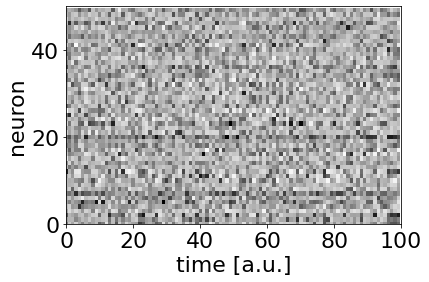

In [3]:
plt.figure()
Yplot = Y[:, :, 0]
plt.imshow(Yplot, cmap='Greys', aspect='auto')
plt.xlabel("time [a.u.]")
plt.ylabel("neuron")
plt.xlim(0,100)
plt.ylim(0,n)
plt.show()
plt.close()

In [4]:
# train model
trained_mod = training.svgp(Y, 
                           mod, 
                           device, 
                           optimizer=optim.Adam, 
                           outdir='none', 
                           max_steps=500, 
                           burnin=150, 
                           n_mc=64, 
                           lrate=5E-2, 
                           print_every=50)

data = torch.tensor(Y, dtype=torch.get_default_dtype()).to(device)
mod = mod.to(device)
mulearn = mod.lat_dist.manif.prms.data.cpu()
mutrue = gen.gs[0]
plearn = mod.lat_dist.manif.distance(mulearn.T, mulearn.T).numpy()
ptrue = gen.manifold.manifs[0].distance(mutrue, mutrue)
ptrue, plearn = [p.flatten() for p in [ptrue, plearn]]

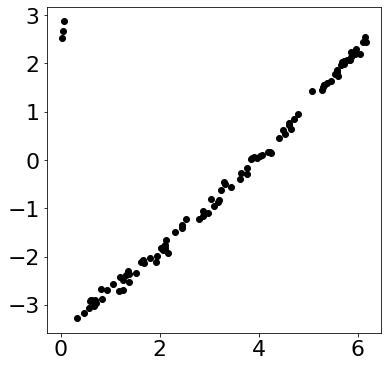

In [5]:
gs_true = gen.gs[0]
gprefs_true = gen.gprefs[0]
g_mus = mod.lat_dist.manif.prms.data.cpu().numpy()[:]
plt.figure(figsize=(6,6))
plt.plot(gs_true[:, 0], g_mus[:, 0], "ko")
plt.show()
plt.close()

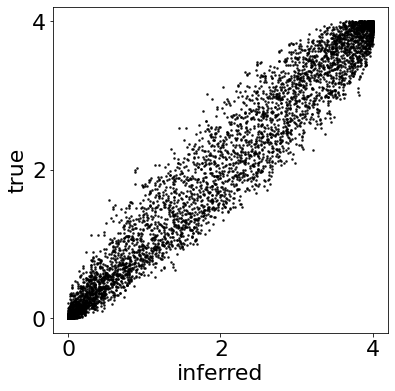

In [6]:
plt.figure(figsize=(6, 6))
plt.plot(plearn, ptrue, "ko", markersize=1.5, alpha=0.5)
plt.xlabel("inferred")
plt.ylabel("true")
plt.xticks((0, 2, 4), ("$0$", "$2$", "$4$"))
plt.yticks((0, 2, 4), ("$0$", "$2$", "$4$"))
plt.show()
plt.close()

In [21]:
#align model to ground truth

mod = align.align_torus(mod, gen.gs[0])

# %% compute mse
query = mod.lat_dist.manif.mu.detach()
print(query.shape)
fmean, fstd = mod.svgp.predict(query.T[None, :, :], False)
var = np.mean(np.var(Y, axis=1))
MSE = np.mean(((fmean - data)**2).detach().cpu().numpy())
print('MSE:', MSE, 'var:', var)
print(fmean.shape)


coordinate system: [[-1]] 0 loss: 1.9743901545403477
coordinate system: [[-1]] 1 loss: 1.9743901545005078
coordinate system: [[-1]] 2 loss: 2.006035444576503
coordinate system: [[-1]] 3 loss: 1.9743901545005063
coordinate system: [[-1]] 4 loss: 2.0137096702313535
coordinate system: [[1]] 0 loss: 0.021756155501105
coordinate system: [[1]] 1 loss: 0.02175615539589951
coordinate system: [[1]] 2 loss: 0.021756155560516
coordinate system: [[1]] 3 loss: 0.021756155507188943
coordinate system: [[1]] 4 loss: 0.021756155396113613
torch.Size([100, 1])
MSE: 0.4156117750778008 var: 0.20612556251664876
torch.Size([1, 50, 100, 1])


torch.Size([50, 50, 1]) torch.Size([50]) torch.Size([1, 50, 50])


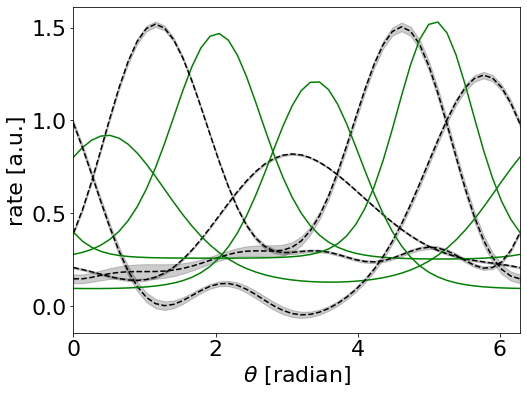

In [30]:
#%% consider 'tuning curves'
query = torch.tensor(np.linspace(0, 2 * np.pi, 50),
                     dtype=torch.get_default_dtype(),
                     device=device)

fmean, fstd = mod.svgp.predict(query[None, None, :], False)
fmean = fmean[0, :, :, :]
#fstd = fstd.transpose(1,2,0)
print(fmean.shape, query.shape, fstd.shape)

inds = [np.argmin((gen.gprefs[0] - val)**2) for val in 0.5 + np.arange(4) * 1.5]
plt.figure(figsize=(8, 6))

for i in inds:
    xs, m, std = [arr.detach().cpu().numpy() for arr in [query, fmean, fstd]]
    m, std = [arr[i, :, 0] for arr in [m, std.transpose(1,2,0)]]
    plt.plot(xs, m, "k--")
    plt.fill_between(xs, m - 2 * std, m + 2 * std, color='k', alpha=0.2)
    true_y = gen.gen_data(gs_in=[xs.reshape(-1, 1)], sigma=np.zeros((mod.n, 1)))
    plt.plot(xs, true_y[i, :, 0], 'g-')

plt.xlabel(r"$\theta$ [radian]")
plt.ylabel(r"rate [a.u.]")
plt.xlim(0, 2 * np.pi)
plt.show()
plt.close()